In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the datasets
gdp_data = pd.read_csv('gdp_quarterly_2013_2023.csv')
bank_data = pd.read_csv('Dataset of BankIndustry.csv')

# Convert Date columns to datetime format
gdp_data['Date'] = pd.to_datetime(gdp_data['Date'])
bank_data['Date'] = pd.to_datetime(bank_data['Date'], errors='coerce')

# Extract Quarter information to align the datasets
gdp_data['Quarter'] = gdp_data['Date'].dt.to_period('Q')
bank_data['Quarter'] = bank_data['Date'].dt.to_period('Q')

# Merge datasets on 'Quarter'
merged_data = pd.merge(gdp_data, bank_data, on='Quarter', how='inner')

# Select relevant columns
merged_data_cleaned = merged_data[['Quarterly_GDP'] + 
                                   [col for col in bank_data.columns if col not in ['Quarter-Year', 'quarter', 'year', 'Date', 'Quarter']]]

# Convert columns to numeric, handling non-numeric entries
for col in merged_data_cleaned.columns:
    merged_data_cleaned[col] = pd.to_numeric(merged_data_cleaned[col], errors='coerce')

# Drop columns with more than 50% missing values
threshold = len(merged_data_cleaned) * 0.5
cleaned_data = merged_data_cleaned.dropna(thresh=threshold, axis=1)

# Impute remaining missing values with median
imputer = SimpleImputer(strategy='median')
cleaned_data_imputed = pd.DataFrame(imputer.fit_transform(cleaned_data), columns=cleaned_data.columns)

# Separate features and target variable
X = cleaned_data_imputed.drop(columns=['Quarterly_GDP'])
y = cleaned_data_imputed['Quarterly_GDP']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize models
rf_model = RandomForestRegressor(random_state=42)
xgb_model = XGBRegressor(n_estimators=50, max_depth=3, random_state=42)  # Limited to reduce training time
lr_model = LinearRegression()

# Train models
rf_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)

# Make predictions
rf_preds = rf_model.predict(X_test)
xgb_preds = xgb_model.predict(X_test)
lr_preds = lr_model.predict(X_test)

# Calculate evaluation metrics
rf_mse = mean_squared_error(y_test, rf_preds)
xgb_mse = mean_squared_error(y_test, xgb_preds)
lr_mse = mean_squared_error(y_test, lr_preds)

rf_r2 = r2_score(y_test, rf_preds)
xgb_r2 = r2_score(y_test, xgb_preds)
lr_r2 = r2_score(y_test, lr_preds)

# Model performance results
model_performance = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost', 'Linear Regression'],
    'MSE': [rf_mse, xgb_mse, lr_mse],
    'R2 Score': [rf_r2, xgb_r2, lr_r2]
})

print(model_performance)


C:\Users\Vinh\AppData\Local\Temp\ipykernel_23152\2747916600.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_cleaned[col] = pd.to_numeric(merged_data_cleaned[col], errors='coerce')


               Model           MSE  R2 Score
0      Random Forest  8.375993e+10  0.572137
1            XGBoost  1.042395e+11  0.467523
2  Linear Regression  8.356165e+10  0.573150


In [2]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

# Load and prepare the data
gdp_data = pd.read_csv('gdp_quarterly_2013_2023.csv')
bank_data = pd.read_csv('Dataset of BankIndustry.csv')

# Convert Date columns to datetime format and align quarters
gdp_data['Date'] = pd.to_datetime(gdp_data['Date'])
bank_data['Date'] = pd.to_datetime(bank_data['Date'], errors='coerce')
gdp_data['Quarter'] = gdp_data['Date'].dt.to_period('Q')
bank_data['Quarter'] = bank_data['Date'].dt.to_period('Q')

# Merge datasets
merged_data = pd.merge(gdp_data, bank_data, on='Quarter', how='inner')
merged_data_cleaned = merged_data[['Quarterly_GDP'] + 
                                   [col for col in bank_data.columns if col not in ['Quarter-Year', 'quarter', 'year', 'Date', 'Quarter']]]
for col in merged_data_cleaned.columns:
    merged_data_cleaned[col] = pd.to_numeric(merged_data_cleaned[col], errors='coerce')

# Drop columns with many missing values and impute remaining missing values
threshold = len(merged_data_cleaned) * 0.5
cleaned_data = merged_data_cleaned.dropna(thresh=threshold, axis=1)
imputer = SimpleImputer(strategy='median')
cleaned_data_imputed = pd.DataFrame(imputer.fit_transform(cleaned_data), columns=cleaned_data.columns)

# Split data into training and test sets
train_size = int(len(cleaned_data_imputed) * 0.8)
train_data, test_data = cleaned_data_imputed.iloc[:train_size], cleaned_data_imputed.iloc[train_size:]

# Separate target and exogenous variables
train_endog = train_data['Quarterly_GDP']
train_exog = train_data.drop(columns=['Quarterly_GDP'])
test_endog = test_data['Quarterly_GDP']
test_exog = test_data.drop(columns=['Quarterly_GDP'])

# Define SARIMAX parameters and train the model
sarimax_order = (1, 1, 1)        # ARIMA(p, d, q)
seasonal_order = (1, 1, 1, 4)    # Quarterly seasonality (P, D, Q, s)

sarimax_model = SARIMAX(train_endog, exog=train_exog, order=sarimax_order, seasonal_order=seasonal_order)
sarimax_result = sarimax_model.fit(disp=False)

# Forecast and calculate MAPE
sarimax_forecast = sarimax_result.predict(start=len(train_data), end=len(cleaned_data_imputed)-1, exog=test_exog)
sarimax_mape = mean_absolute_percentage_error(test_endog, sarimax_forecast)

print(f"SARIMAX MAPE: {sarimax_mape:.4%}")


C:\Users\Vinh\AppData\Local\Temp\ipykernel_23152\2905893287.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_cleaned[col] = pd.to_numeric(merged_data_cleaned[col], errors='coerce')
f:\Python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
f:\Python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMAX MAPE: 6.9440%


In [4]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split

# Ensure data preparation is consistent
X = cleaned_data_imputed.drop(columns=['Quarterly_GDP'])
y = cleaned_data_imputed['Quarterly_GDP']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Refined XGBoost model configuration
xgb_model_refined = XGBRegressor(
    n_estimators=100,       # Slightly increased tree count for better accuracy
    max_depth=4,            # Depth increased to allow model complexity
    learning_rate=0.05,     # Lowered to capture finer patterns
    subsample=0.9,          # 90% of data per tree for robustness
    colsample_bytree=0.9,   # 90% of features per tree
    random_state=42
)

# Train and calculate MAPE
xgb_model_refined.fit(X_train, y_train)
xgb_preds_refined = xgb_model_refined.predict(X_test)
xgb_mape_refined = mean_absolute_percentage_error(y_test, xgb_preds_refined)

print(f"Refined XGBoost MAPE: {xgb_mape_refined:.4%}")


Refined XGBoost MAPE: 16.9883%


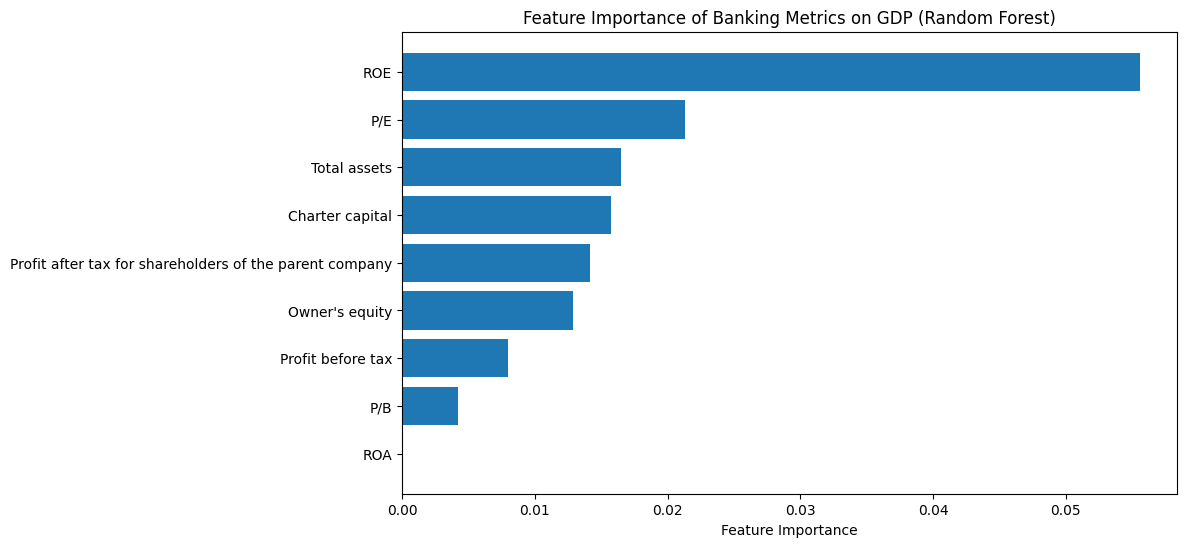

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor

# Fit the Random Forest model again (if necessary)
# rf_model = RandomForestRegressor(random_state=42)
# rf_model.fit(X_train, y_train)

# Extract feature importances and feature names
feature_importances = rf_model.feature_importances_
feature_names = X_train.columns

# Sort features by importance and exclude the top two (% and %.1)
sorted_idx = np.argsort(feature_importances)[::-1][2:]  # Skip the top two features
sorted_feature_importances = feature_importances[sorted_idx]
sorted_feature_names = feature_names[sorted_idx]

# Plot the feature importances excluding the top two
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_names, sorted_feature_importances, align='center')
plt.xlabel("Feature Importance")
plt.title("Feature Importance of Banking Metrics on GDP (Random Forest)")
plt.gca().invert_yaxis()  # Display most important features at the top
plt.show()


In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
import numpy as np

# Load the dataset
# Assuming the dataset is loaded and cleaned as 'cleaned_data_imputed'

# Drop irrelevant columns `%` and `%.1` from the feature set
cleaned_data_imputed = cleaned_data_imputed.drop(columns=['%', '%.1'], errors='ignore')

# Separate features and target variable
X = cleaned_data_imputed.drop(columns=['Quarterly_GDP'])
y = cleaned_data_imputed['Quarterly_GDP']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions and calculate MAPE and RMSE
rf_preds = rf_model.predict(X_test)
rf_mape = mean_absolute_percentage_error(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))

print(f"Random Forest MAPE (after removing % and %.1): {rf_mape:.4%}")
print(f"Random Forest RMSE (after removing % and %.1): {rf_rmse:.2f}")


Random Forest MAPE (after removing % and %.1): 9.4273%
Random Forest RMSE (after removing % and %.1): 182799.87


In [6]:
import seaborn as sns


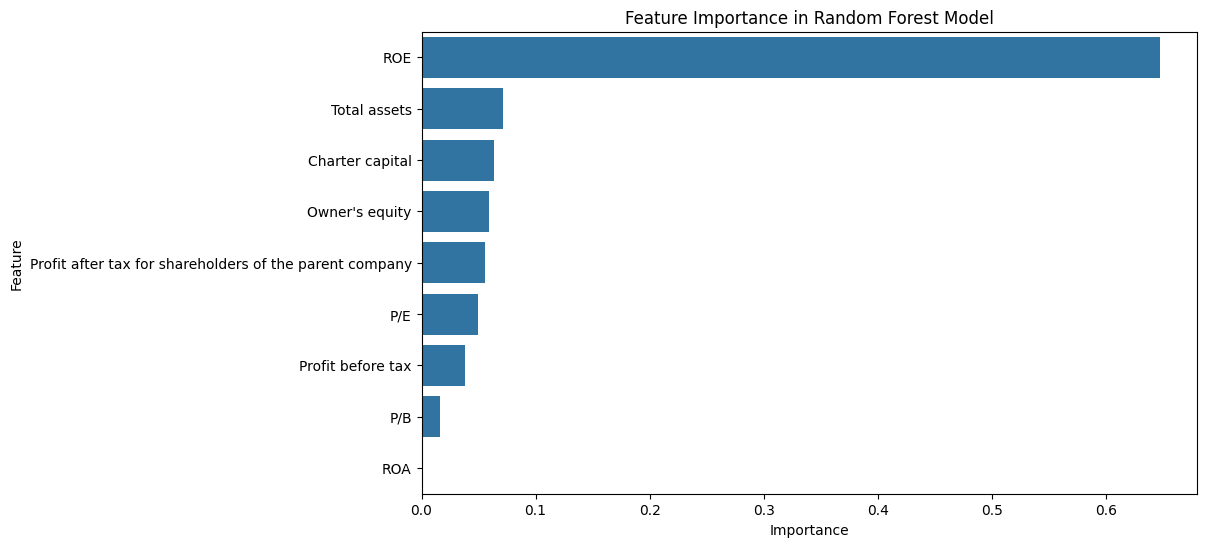

In [7]:
# Get feature importances from the trained model
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for easy plotting
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
plt.title('Feature Importance in Random Forest Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [8]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import pandas as pd

# Step 1: Log transform for ROE to reduce dominance
X['ROE_log'] = np.log1p(X['ROE'])  # Use log(1 + ROE) to avoid log(0) issues
X = X.drop(columns=['ROE'])  # Drop the original ROE to avoid redundancy

# Step 2: Generate interaction and polynomial features (degree 2 for simplicity)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Get the names for the generated polynomial and interaction features
poly_feature_names = poly.get_feature_names_out(X.columns)
X_poly_df = pd.DataFrame(X_poly, columns=poly_feature_names, index=X.index)

# Step 3: Concatenate the original and polynomial features
X_final = pd.concat([X, X_poly_df], axis=1)

# Step 4: Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_final)

# Convert scaled data back to a DataFrame for easier handling
X_scaled_df = pd.DataFrame(X_scaled, columns=X_final.columns, index=X_final.index)

# Re-run the train/test split with the new features and scaling applied
X_train, X_test, y_train, y_test = train_test_split(X_scaled_df, y, test_size=0.2, random_state=42)

# Train and evaluate the model again
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

rf_preds = rf_model.predict(X_test)
rf_mape = mean_absolute_percentage_error(y_test, rf_preds)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_preds))

print(f"Random Forest MAPE (after feature engineering and scaling): {rf_mape:.4%}")
print(f"Random Forest RMSE (after feature engineering and scaling): {rf_rmse:.2f}")


Random Forest MAPE (after feature engineering and scaling): 8.7211%
Random Forest RMSE (after feature engineering and scaling): 171534.06


In [9]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error


In [10]:
# Test different SARIMAX configurations manually
sarimax_model = SARIMAX(y_train, order=(2, 1, 2), seasonal_order=(1, 1, 1, 4)).fit(disp=False)
sarimax_preds = sarimax_model.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, dynamic=False)


f:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
f:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
f:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
f:\Python\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predi

In [11]:
# Adjust weights to find the optimal combination
best_mape = float('inf')
best_weights = (0.6, 0.4)

for rf_weight in [0.5, 0.6, 0.7, 0.8]:
    sarimax_weight = 1 - rf_weight
    ensemble_preds = rf_weight * rf_preds + sarimax_weight * sarimax_preds
    ensemble_mape = mean_absolute_percentage_error(y_test, ensemble_preds)
    if ensemble_mape < best_mape:
        best_mape = ensemble_mape
        best_weights = (rf_weight, sarimax_weight)

print(f"Optimal Weights: Random Forest = {best_weights[0]}, SARIMAX = {best_weights[1]}")
print(f"Ensemble MAPE with Optimal Weights: {best_mape:.4%}")


Optimal Weights: Random Forest = 0.8, SARIMAX = 0.19999999999999996
Ensemble MAPE with Optimal Weights: 13.7488%


In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initialize and perform grid search
grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3, n_jobs=-1, scoring='neg_mean_absolute_percentage_error')
grid_search.fit(X_train, y_train)

# Use the best estimator from the grid search
best_rf = grid_search.best_estimator_
rf_preds = best_rf.predict(X_test)

print("Optimized Random Forest MAPE:", mean_absolute_percentage_error(y_test, rf_preds))


Optimized Random Forest MAPE: 0.09742883475453182


In [13]:
# Final ensemble with optimized weights
ensemble_preds = best_weights[0] * rf_preds + best_weights[1] * sarimax_preds
ensemble_mape = mean_absolute_percentage_error(y_test, ensemble_preds)
ensemble_rmse = np.sqrt(mean_squared_error(y_test, ensemble_preds))

print(f"Final Ensemble MAPE: {ensemble_mape:.4%}")
print(f"Final Ensemble RMSE: {ensemble_rmse:.2f}")


Final Ensemble MAPE: 14.3783%
Final Ensemble RMSE: 273017.29


In [14]:
from sklearn.base import BaseEstimator, RegressorMixin
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Custom wrapper for SARIMAX
class SARIMAXRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, order=(1, 1, 1), seasonal_order=(1, 1, 1, 4)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model_ = None  # Placeholder for the fitted SARIMAX model

    def fit(self, X, y):
        # SARIMAX requires a univariate series  as input, so ignore X and fit on y
        self.model_ = SARIMAX(y, order=self.order, seasonal_order=self.seasonal_order).fit(disp=False)
        return self

    def predict(self, X):
        # Generate predictions for the same length as X
        pred_start = len(self.model_.model.endog)
        pred_end = pred_start + len(X) - 1
        return self.model_.predict(start=pred_start, end=pred_end, dynamic=False)

# Initialize the SARIMAX regressor with the desired parameters
sarimax_regressor = SARIMAXRegressor(order=(2, 1, 2), seasonal_order=(1, 1, 1, 4))

# Now define the stacking regressor with the custom SARIMAX wrapper and Random Forest
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

# Define base models
base_models = [
    ('rf', best_rf),                      # Optimized Random Forest model
    ('sarimax', sarimax_regressor)        # Wrapped SARIMAX model
]

# Define the meta-model (Linear Regression)
stacking_model = StackingRegressor(
    estimators=base_models,
    final_estimator=LinearRegression(),
    cv=3
)

# Fit the stacking model on the training data
stacking_model.fit(X_train, y_train)

# Make predictions on the test set
stacking_preds = stacking_model.predict(X_test)

# Evaluate the stacking model
stacking_mape = mean_absolute_percentage_error(y_test, stacking_preds)
stacking_rmse = np.sqrt(mean_squared_error(y_test, stacking_preds))

print(f"Stacking Model MAPE: {stacking_mape:.4%}")
print(f"Stacking Model RMSE: {stacking_rmse:.2f}")


f:\Python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
f:\Python\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
f:\Python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:997: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


Stacking Model MAPE: 9.5279%
Stacking Model RMSE: 199779.55


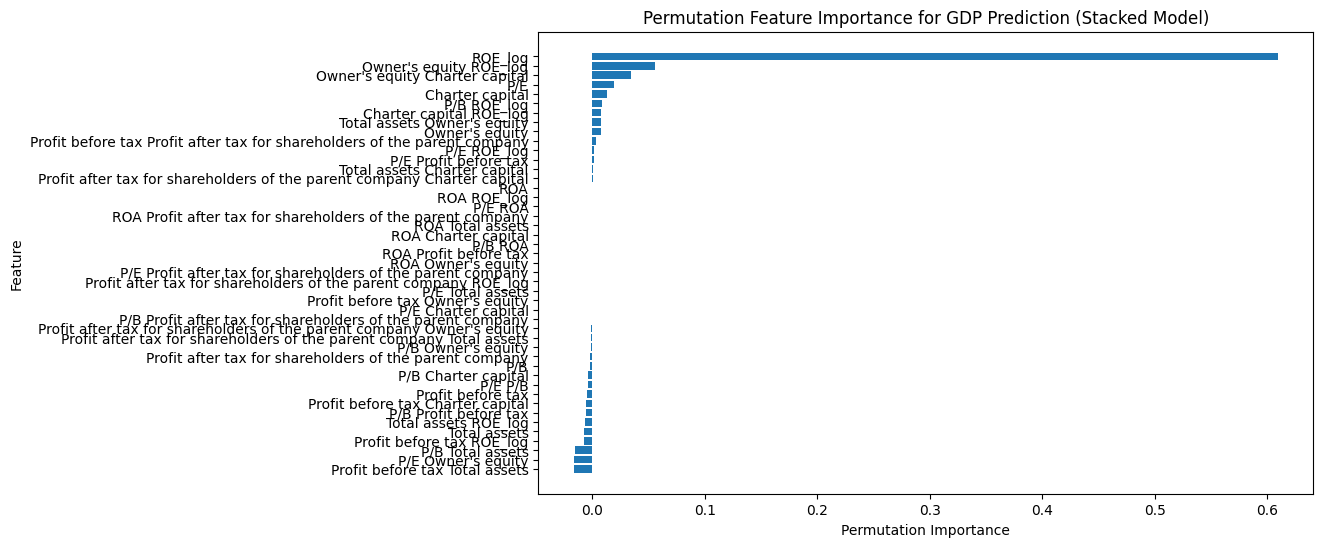

In [15]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# Calculate permutation importance for the stacked model
perm_importance = permutation_importance(stacking_model, X_test, y_test, n_repeats=10, random_state=42)

# Extract the feature importances and feature names
importance_scores = perm_importance.importances_mean
feature_names = X_test.columns

# Create a DataFrame for easy visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance_scores})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting the permutation importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Permutation Feature Importance for GDP Prediction (Stacked Model)')
plt.gca().invert_yaxis()
plt.show()


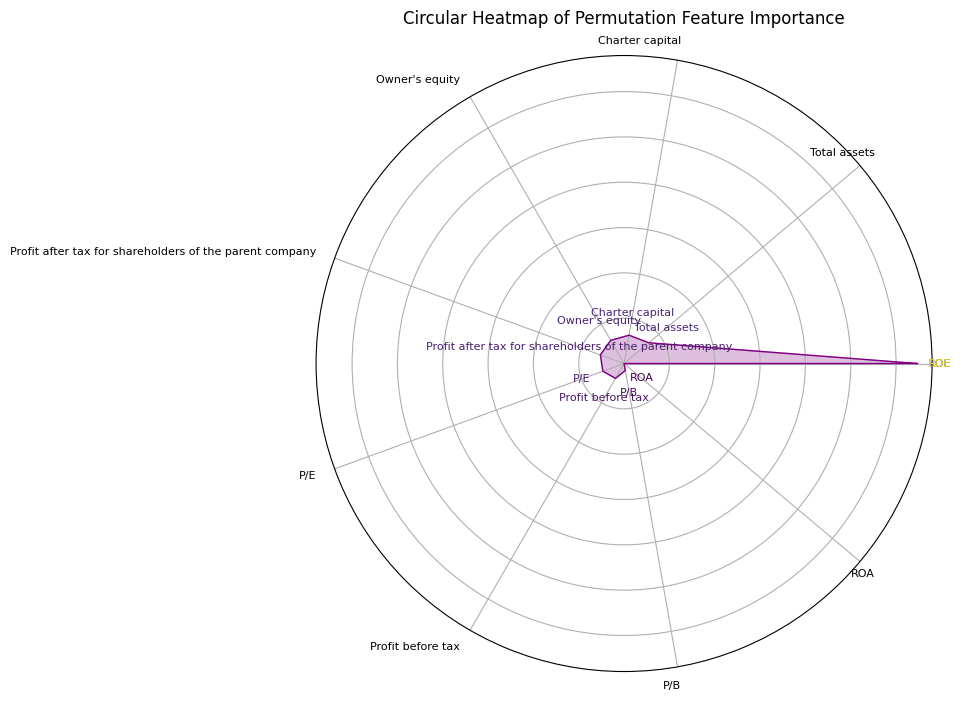

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import cm

# Assuming feature_importance_df is already sorted and contains 'Feature' and 'Importance'

# Number of features
num_features = len(feature_importance_df)

# Set up the figure and polar axis
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})

# Set the angles for each feature in radians
angles = np.linspace(0, 2 * np.pi, num_features, endpoint=False).tolist()

# Repeat the first angle to close the circle
angles += angles[:1]
feature_importances = feature_importance_df['Importance'].values
feature_importances = np.append(feature_importances, feature_importances[0])  # Close the loop

# Normalize the feature importances for color mapping
norm = plt.Normalize(min(feature_importances), max(feature_importances))
colors = cm.viridis(norm(feature_importances))

# Plot each feature as a point in the polar plot
ax.plot(angles, feature_importances, color='purple', linewidth=1, linestyle='solid')
ax.fill(angles, feature_importances, color='purple', alpha=0.25)

# Set the labels for each angle
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(feature_importance_df['Feature'], fontsize=8, rotation=45, ha='right')

# Color each feature label based on its importance
for i, (angle, color) in enumerate(zip(angles[:-1], colors)):
    ax.text(angle, feature_importances[i] + 0.05, feature_importance_df['Feature'].iloc[i],
            ha='center', va='center', color=color, fontsize=8)

# Add title
plt.title('Circular Heatmap of Permutation Feature Importance', va='bottom')

plt.show()


In [16]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.impute import SimpleImputer

# Load and prepare the data
gdp_data = pd.read_csv('gdp_quarterly_2013_2023.csv')
bank_data = pd.read_csv('Dataset of BankIndustry.csv')

# Convert Date columns to datetime format and align quarters
gdp_data['Date'] = pd.to_datetime(gdp_data['Date'])
bank_data['Date'] = pd.to_datetime(bank_data['Date'], errors='coerce')
gdp_data['Quarter'] = gdp_data['Date'].dt.to_period('Q')
bank_data['Quarter'] = bank_data['Date'].dt.to_period('Q')

# Merge datasets
merged_data = pd.merge(gdp_data, bank_data, on='Quarter', how='inner')
selected_features = [
    'ROE', 'Total assets', 'Charter capital', "Owner's equity",
    'Profit after tax for shareholders of the parent company', 'P/E',
    'Profit before tax', 'P/B', 'ROA'
]
merged_data_cleaned = merged_data[['Quarterly_GDP'] + selected_features]

# Handle missing values
imputer = SimpleImputer(strategy='median')
cleaned_data = pd.DataFrame(imputer.fit_transform(merged_data_cleaned), columns=merged_data_cleaned.columns)

# Split into train and test sets
train_size = int(len(cleaned_data) * 0.8)
train_data, test_data = cleaned_data.iloc[:train_size], cleaned_data.iloc[train_size:]
X_train, y_train = train_data[selected_features], train_data['Quarterly_GDP']
X_test, y_test = test_data[selected_features], test_data['Quarterly_GDP']

# Define SARIMAX Wrapper
class SARIMAXRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, order=(2, 1, 2), seasonal_order=(1, 1, 1, 4)):
        self.order = order
        self.seasonal_order = seasonal_order
        self.model_ = None

    def fit(self, X, y):
        self.model_ = SARIMAX(y, order=self.order, seasonal_order=self.seasonal_order).fit(disp=False)
        return self

    def predict(self, X):
        pred_start = len(self.model_.model.endog)
        pred_end = pred_start + len(X) - 1
        return self.model_.predict(start=pred_start, end=pred_end, dynamic=False)

# Initialize SARIMAX and Random Forest
sarimax_regressor = SARIMAXRegressor(order=(2, 1, 2), seasonal_order=(1, 1, 1, 4))
best_rf = RandomForestRegressor(n_estimators=100, random_state=42)

# Define the Stacking Regressor with SARIMAX and Random Forest
stacking_model = StackingRegressor(
    estimators=[
        ('rf', best_rf),
        ('sarimax', sarimax_regressor)
    ],
    final_estimator=LinearRegression(),
    cv=3
)

# Fit the stacking model on training data
stacking_model.fit(X_train, y_train)

# Make predictions on the test set
stacking_preds = stacking_model.predict(X_test)

# Evaluate the stacking model
stacking_mape = mean_absolute_percentage_error(y_test, stacking_preds)
stacking_rmse = np.sqrt(mean_squared_error(y_test, stacking_preds))

print(f"Stacking Model MAPE: {stacking_mape:.4%}")
print(f"Stacking Model RMSE: {stacking_rmse:.2f}")

# If needed, use the model to forecast future GDP values by providing future data for selected features


f:\Python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
f:\Python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
f:\Python\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
f:\Python\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
f:\Python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving 

Stacking Model MAPE: 37.1214%
Stacking Model RMSE: 946775.93


In [26]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_percentage_error

# Load and prepare the data as before
gdp_data = pd.read_csv('gdp_quarterly_2013_2023.csv')
bank_data = pd.read_csv('Dataset of BankIndustry.csv')

# Data preparation steps
gdp_data['Date'] = pd.to_datetime(gdp_data['Date'])
bank_data['Date'] = pd.to_datetime(bank_data['Date'], errors='coerce')
gdp_data['Quarter'] = gdp_data['Date'].dt.to_period('Q')
bank_data['Quarter'] = bank_data['Date'].dt.to_period('Q')

# Merge and select important features
selected_features = [
    'ROE', 'Total assets', 'Charter capital', "Owner's equity",
    'Profit after tax for shareholders of the parent company', 'P/E',
    'Profit before tax', 'P/B', 'ROA'
]
merged_data = pd.merge(gdp_data, bank_data, on='Quarter', how='inner')
merged_data_cleaned = merged_data[['Quarterly_GDP'] + selected_features]

# Impute missing values
imputer = SimpleImputer(strategy='median')
cleaned_data = pd.DataFrame(imputer.fit_transform(merged_data_cleaned), columns=merged_data_cleaned.columns)

# Split into training and test sets
train_size = int(len(cleaned_data) * 0.8)
train_data, test_data = cleaned_data.iloc[:train_size], cleaned_data.iloc[train_size:]
train_endog, test_endog = train_data['Quarterly_GDP'], test_data['Quarterly_GDP']
train_exog, test_exog = train_data[selected_features], test_data[selected_features]

# Define and fit the SARIMAX model
sarimax_order = (2, 1, 2)
seasonal_order = (1, 1, 1, 4)
sarimax_model = SARIMAX(train_endog, exog=train_exog, order=sarimax_order, seasonal_order=seasonal_order)
sarimax_result = sarimax_model.fit(disp=False)

# Make predictions on the test set
sarimax_forecast = sarimax_result.predict(start=len(train_data), end=len(cleaned_data)-1, exog=test_exog)
sarimax_mape = mean_absolute_percentage_error(test_endog, sarimax_forecast)

print(f"SARIMAX Standalone Model MAPE: {sarimax_mape:.4%}")


f:\Python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SARIMAX Standalone Model MAPE: 6.8286%


f:\Python\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


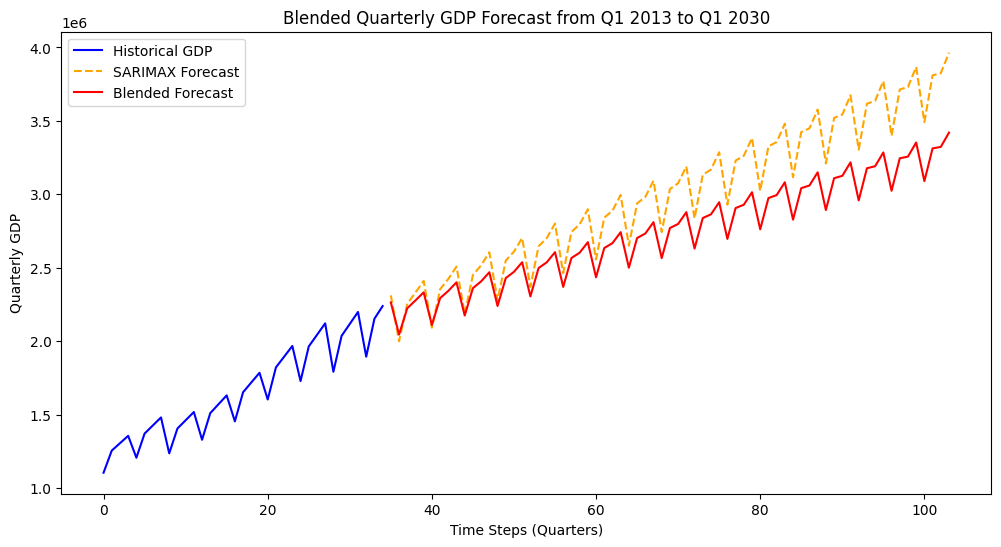

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_percentage_error

# Define SARIMAX parameters and fit on GDP data with exogenous variables
sarimax_order = (2, 1, 2)
seasonal_order = (1, 1, 1, 4)
sarimax_model = SARIMAX(y_train, exog=X_train, order=sarimax_order, seasonal_order=seasonal_order)
sarimax_result = sarimax_model.fit(disp=False)

# Forecast using SARIMAX for the period up to Q1 2030
future_periods = (2030 - 2013) * 4 + 1
start_forecast = len(X_train)
end_forecast = start_forecast + future_periods - 1
future_exog_df = pd.DataFrame(np.tile(X_train.iloc[-1].values, (future_periods, 1)), columns=X_train.columns)

# Generate SARIMAX forecasts
sarimax_forecast = sarimax_result.predict(start=start_forecast, end=end_forecast, exog=future_exog_df)

# Train the Random Forest model on the historical data
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Generate Random Forest predictions for the same future periods
rf_forecast = rf_model.predict(future_exog_df)

# Blend the SARIMAX and Random Forest predictions
# Define weights (adjust as needed based on model performance)
sarimax_weight = 0.7  # Give more weight to SARIMAX for capturing time series trends
rf_weight = 0.3       # Give less weight to Random Forest
blended_forecast = sarimax_weight * sarimax_forecast + rf_weight * rf_forecast

# Plot the historical data and the blended forecast
plt.figure(figsize=(12, 6))
plt.plot(y_train.reset_index(drop=True), label="Historical GDP", color="blue")
plt.plot(range(start_forecast, end_forecast + 1), sarimax_forecast, label="SARIMAX Forecast", linestyle='--', color="orange")
plt.plot(range(start_forecast, end_forecast + 1), blended_forecast, label="Blended Forecast", linestyle='-', color="red")
plt.title("Blended Quarterly GDP Forecast from Q1 2013 to Q1 2030")
plt.xlabel("Time Steps (Quarters)")
plt.ylabel("Quarterly GDP")
plt.legend()
plt.show()

# Calculate MAPE for the blended forecast on the test set (if applicable)
# test_mape = mean_absolute_percentage_error(y_test, blended_forecast[:len(y_test)])
# print(f"Blended Model MAPE: {test_mape:.4%}")


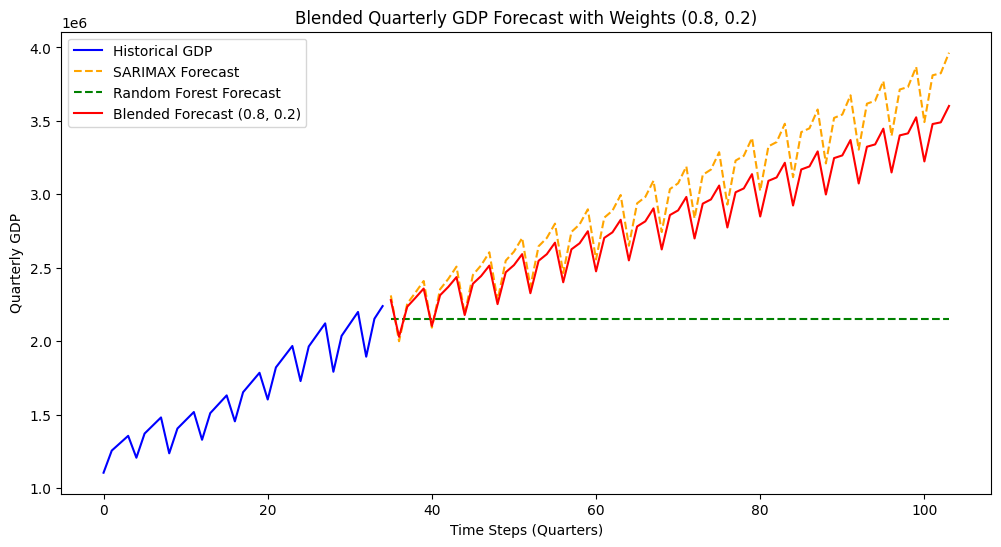

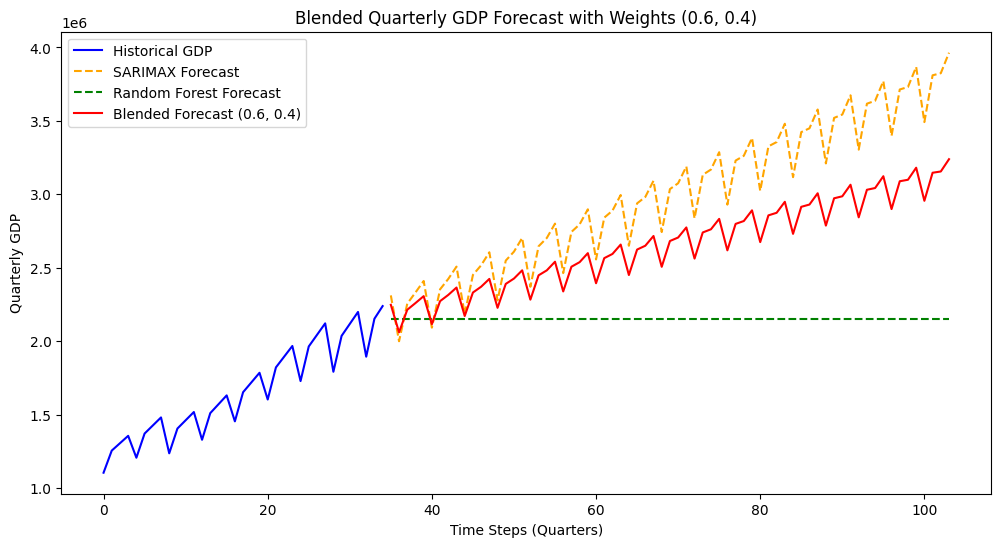

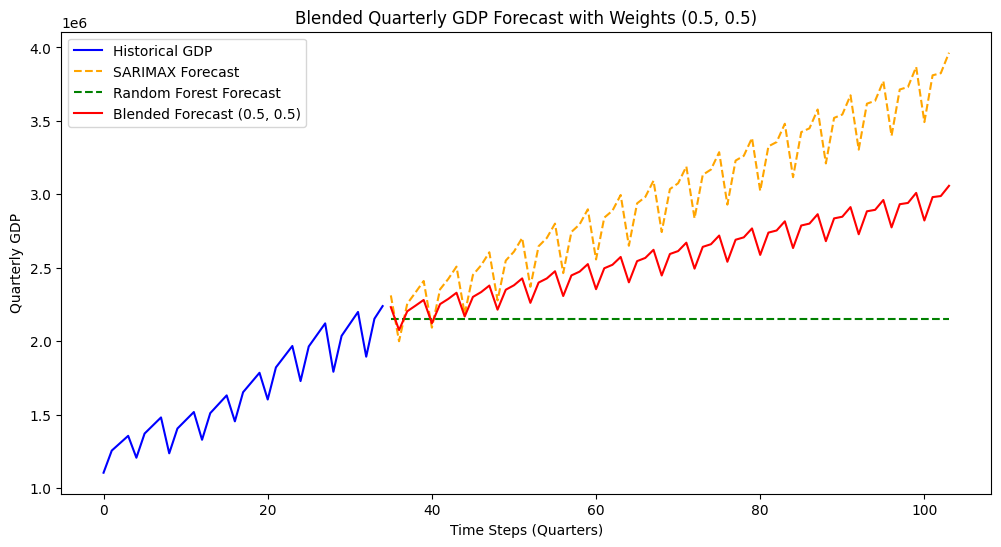

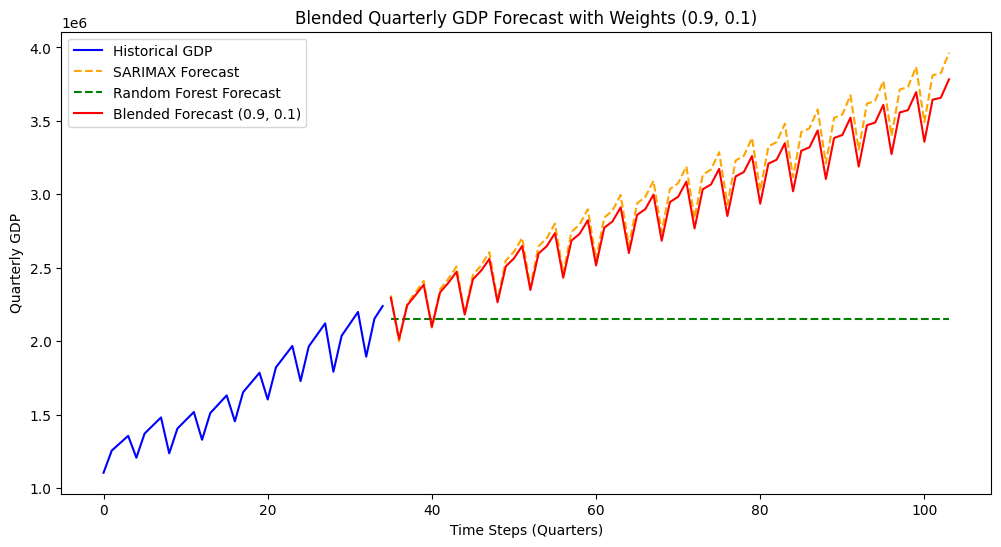

MAPE Results for Different Weight Combinations:
Weights (0.8, 0.2): MAPE = 7.2694%
Weights (0.6, 0.4): MAPE = 8.3759%
Weights (0.5, 0.5): MAPE = 8.9292%
Weights (0.9, 0.1): MAPE = 6.7161%


In [28]:
# Define different weight combinations to test
weight_combinations = [
    (0.8, 0.2),  # More weight on SARIMAX
    (0.6, 0.4),  # Balanced, but still favors SARIMAX
    (0.5, 0.5),  # Equal weight for both models
    (0.9, 0.1)   # Strong preference for SARIMAX
]

# Store MAPE results for each combination
mape_results = {}

for sarimax_weight, rf_weight in weight_combinations:
    # Blend the predictions
    blended_forecast = sarimax_weight * sarimax_forecast + rf_weight * rf_forecast
    
    # Calculate MAPE for comparison (if y_test is available)
    if 'y_test' in globals():
        mape = mean_absolute_percentage_error(y_test, blended_forecast[:len(y_test)])
        mape_results[(sarimax_weight, rf_weight)] = mape
    
    # Plot the blended forecast for visual comparison
    plt.figure(figsize=(12, 6))
    plt.plot(y_train.reset_index(drop=True), label="Historical GDP", color="blue")
    plt.plot(range(start_forecast, end_forecast + 1), sarimax_forecast, label="SARIMAX Forecast", linestyle='--', color="orange")
    plt.plot(range(start_forecast, end_forecast + 1), rf_forecast, label="Random Forest Forecast", linestyle='--', color="green")
    plt.plot(range(start_forecast, end_forecast + 1), blended_forecast, label=f"Blended Forecast ({sarimax_weight}, {rf_weight})", linestyle='-', color="red")
    plt.title(f"Blended Quarterly GDP Forecast with Weights ({sarimax_weight}, {rf_weight})")
    plt.xlabel("Time Steps (Quarters)")
    plt.ylabel("Quarterly GDP")
    plt.legend()
    plt.show()

# Display MAPE results if available
if mape_results:
    print("MAPE Results for Different Weight Combinations:")
    for weights, mape in mape_results.items():
        print(f"Weights {weights}: MAPE = {mape:.4%}")


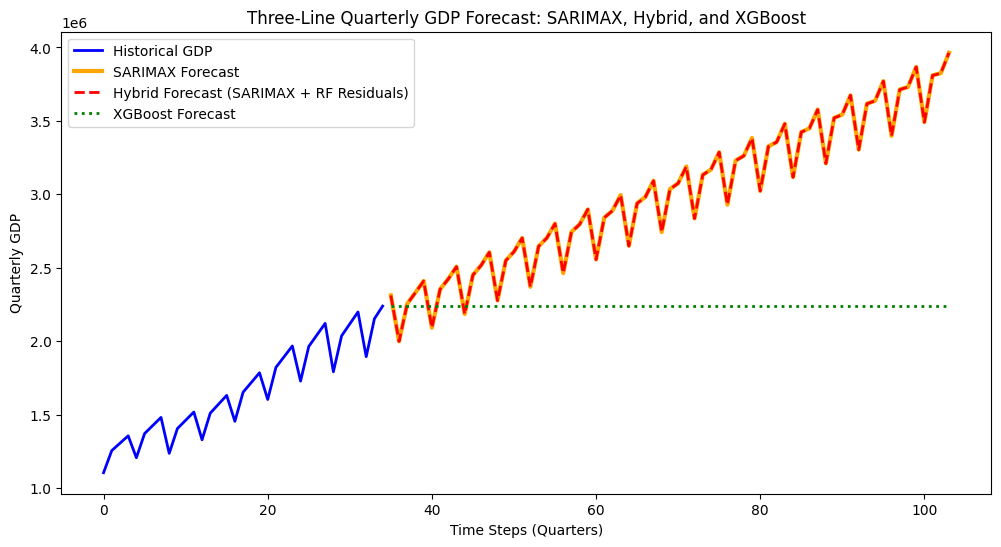

SARIMAX MAPE: 6.1628%
Hybrid Model MAPE: 6.1884%
XGBoost MAPE: 9.5265%


In [73]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_percentage_error

# Step 1: Generate predictions for SARIMAX (already defined as sarimax_forecast) and Hybrid (SARIMAX + RF Residuals)

# Step 2: Train an XGBoost model on the original data
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)

# Generate XGBoost predictions for the future periods
xgb_forecast = xgb_model.predict(future_exog_df)

# Step 3: Plot the three-line prediction for comparison
plt.figure(figsize=(12, 6))
plt.plot(y_train.reset_index(drop=True), label="Historical GDP", color="blue", linewidth=2)
plt.plot(range(start_forecast, end_forecast + 1), sarimax_forecast, label="SARIMAX Forecast", linestyle='-', color="orange", linewidth=3)
plt.plot(range(start_forecast, end_forecast + 1), hybrid_forecast, label="Hybrid Forecast (SARIMAX + RF Residuals)", linestyle='--', color="red", linewidth=2)
plt.plot(range(start_forecast, end_forecast + 1), xgb_forecast, label="XGBoost Forecast", linestyle=':', color="green", linewidth=2)
plt.title("Three-Line Quarterly GDP Forecast: SARIMAX, Hybrid, and XGBoost")
plt.xlabel("Time Steps (Quarters)")
plt.ylabel("Quarterly GDP")
plt.legend()
plt.show()

# Optional: Print MAPE for each model if y_test is available for validation
if 'y_test' in globals():
    sarimax_mape = mean_absolute_percentage_error(y_test, sarimax_forecast[:len(y_test)])
    hybrid_mape = mean_absolute_percentage_error(y_test, hybrid_forecast[:len(y_test)])
    xgb_mape = mean_absolute_percentage_error(y_test, xgb_forecast[:len(y_test)])
    print(f"SARIMAX MAPE: {sarimax_mape:.4%}")
    print(f"Hybrid Model MAPE: {hybrid_mape:.4%}")
    print(f"XGBoost MAPE: {xgb_mape:.4%}")


f:\Python\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\Vinh\AppData\Local\Temp\ipykernel_23152\2284331045.py:15: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  quarters_future = pd.date_range(start=quarters[len(y_train)], periods=future_periods, freq='Q')


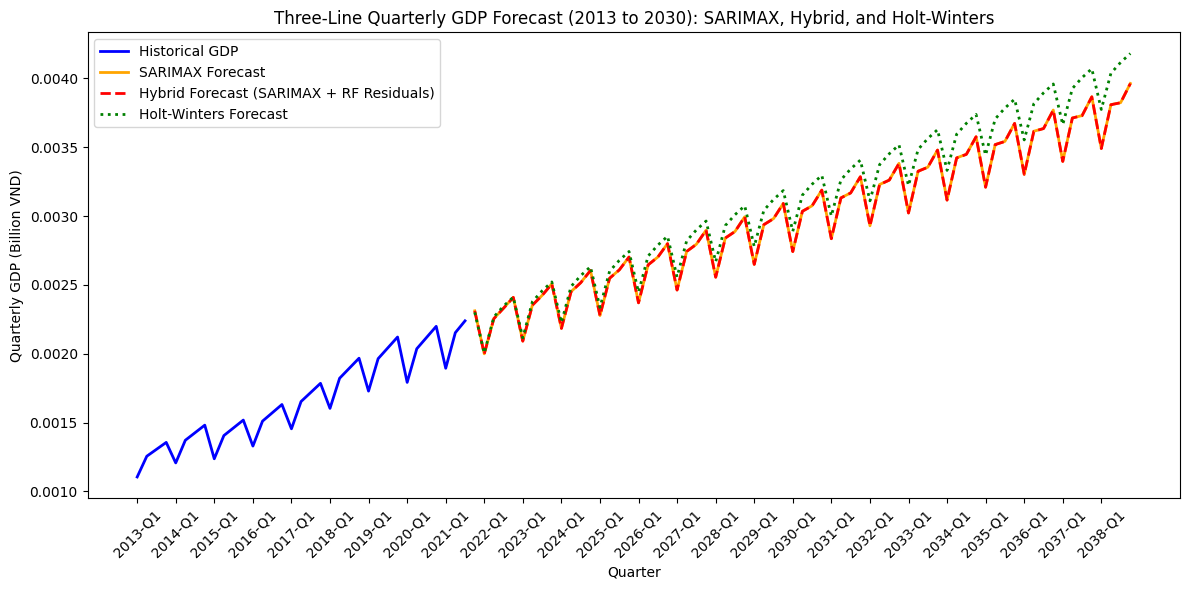

In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_percentage_error

# Xác định số quý dự báo từ thời điểm hiện tại đến 2030
future_periods = len(quarters) - len(y_train)  # Số quý dự báo phù hợp với toàn bộ khoảng thời gian đến 2030

# Dự báo Holt-Winters cho tất cả các quý đến 2030
holt_winters_model = ExponentialSmoothing(y_train, trend='add', seasonal='add', seasonal_periods=4).fit()
holt_winters_forecast = holt_winters_model.forecast(steps=future_periods)

# Cập nhật dữ liệu cho `quarters_future` với toàn bộ khoảng thời gian dự báo
quarters_future = pd.date_range(start=quarters[len(y_train)], periods=future_periods, freq='Q')

# Chuyển đổi GDP sang tỷ đồng
historical_gdp = y_train.reset_index(drop=True) / 1e9
sarimax_forecast_b = sarimax_forecast / 1e9
hybrid_forecast_b = hybrid_forecast / 1e9
holt_winters_forecast_b = holt_winters_forecast / 1e9

# Vẽ biểu đồ với toàn bộ dự báo đến 2030
plt.figure(figsize=(12, 6))
plt.plot(quarters[:len(historical_gdp)], historical_gdp, label="Historical GDP", color="blue", linewidth=2)
plt.plot(quarters_future, sarimax_forecast_b, label="SARIMAX Forecast", linestyle='-', color="orange", linewidth=2)
plt.plot(quarters_future, hybrid_forecast_b, label="Hybrid Forecast (SARIMAX + RF Residuals)", linestyle='--', color="red", linewidth=2)
plt.plot(quarters_future, holt_winters_forecast_b, label="Holt-Winters Forecast", linestyle=':', color="green", linewidth=2)

# Thiết lập nhãn và tiêu đề
plt.title("Three-Line Quarterly GDP Forecast (2013 to 2030): SARIMAX, Hybrid, and Holt-Winters")
plt.xlabel("Quarter")
plt.ylabel("Quarterly GDP (Billion VND)")
plt.legend()

# Giãn nhãn trục x-axis để tránh chồng chéo, hiển thị mỗi năm một nhãn
plt.xticks(quarters[::4], [f"{q.year}-Q{q.quarter}" for q in quarters[::4]], rotation=45)

plt.tight_layout()
plt.show()



In [81]:
import pandas as pd

# Giả sử `historical_gdp` là chuỗi GDP lịch sử đã được chuẩn bị trước (theo tỷ đồng)
# `forecasted_gdp` là dự báo GDP từ năm hiện tại đến năm 2030
# Kết hợp dữ liệu lịch sử và dự báo để tính mức tăng trưởng

# Kết hợp dữ liệu lịch sử và dự báo
gdp_series = pd.concat([historical_gdp, sarimax_forecast_b])

# Tính toán
start_gdp = gdp_series.iloc[0]  # GDP đầu tiên trong chuỗi
end_gdp = gdp_series.iloc[-1]   # GDP cuối cùng trong chuỗi

# Số quý và số năm
n_quarters = len(gdp_series)
n_years = n_quarters / 4

# 1. Tổng mức tăng trưởng
total_growth = ((end_gdp - start_gdp) / start_gdp) * 100

# 2. Tăng trưởng trung bình mỗi quý
average_quarterly_growth = (end_gdp / start_gdp) ** (1 / n_quarters) - 1
average_quarterly_growth_percentage = average_quarterly_growth * 100

# 3. Tăng trưởng trung bình mỗi năm
average_yearly_growth = (end_gdp / start_gdp) ** (1 / n_years) - 1
average_yearly_growth_percentage = average_yearly_growth * 100

print(f"Tổng mức tăng trưởng GDP: {total_growth:.2f}%")
print(f"Tăng trưởng trung bình mỗi quý: {average_quarterly_growth_percentage:.2f}%")
print(f"Tăng trưởng trung bình mỗi năm: {average_yearly_growth_percentage:.2f}%")


Tổng mức tăng trưởng GDP: 258.76%
Tăng trưởng trung bình mỗi quý: 1.24%
Tăng trưởng trung bình mỗi năm: 5.04%
